In [3]:
from __future__ import print_function
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import numpy.ma as ma

%matplotlib inline
from matplotlib import patheffects
from awips.dataaccess import DataAccessLayer
#import cartopy.feature as cfeat
import datetime

from geopy.geocoders import Nominatim

In [2]:
import GOES_IR_ColorMap as IR

For plotting (ie pcolormesh, imshow, etc.) set the max/min:
vmin=162.  vmax=330.


In [12]:
# Standard map plot
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Plot political/state boundaries handled by Cartopy
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='50m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')
    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
    return fig, ax



In [13]:
# Server, Data Request Type, and Database Table
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.county')

In [14]:
# Define a WFO ID for location
# tie this ID to the mapdata.county column "cwa" for filtering
request.setLocationNames('BOU')
request.addIdentifier('cwa', 'BOU')

# enable location filtering (inLocation)
# locationField is tied to the above cwa definition (BOU)
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')
# This is essentially the same as "'"select count(*) from mapdata.cwa where cwa='BOU';" (=1)
# Get response and create dict of county geometries
response = DataAccessLayer.getGeometryData(request, [])
counties = np.array([])
for ob in response:
    counties = np.append(counties,ob.getGeometry())
print("Using " + str(len(counties)) + " county MultiPolygons")
# All WFO counties merged to a single Polygon
merged_counties = cascaded_union(counties)
envelope = merged_counties.buffer(2)
boundaries=[merged_counties]
bounds = merged_counties.bounds




request.setLocationNames('GLD')
request.addIdentifier('cwa', 'GLD')
# enable location filtering (inLocation)
# locationField is tied to the above cwa definition (BOU)
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')
# This is essentially the same as "'"select count(*) from mapdata.cwa where cwa='BOU';" (=1)
# Get response and create dict of county geometries
response2 = DataAccessLayer.getGeometryData(request, [])
counties2 = np.array([])
for ob in response2:
    counties2 = np.append(counties2,ob.getGeometry())
print("Using " + str(len(counties2)) + " county MultiPolygons")
# All WFO counties merged to a single Polygon
merged_counties2 = cascaded_union(counties2)
envelope2 = merged_counties2.buffer(2)
boundaries2=[merged_counties2]
# Get bounds of this merged Polygon to use as buffered map extent
bounds2 = merged_counties2.bounds
# Get bounds of this merged Polygon to use as buffered map extent


bbox=[bounds[0]-1,bounds[2]+1,bounds[1]-1.5,bounds[3]+1.5]
bbox=[-110,-90,35,45]

Using 23 county MultiPolygons
Using 19 county MultiPolygons


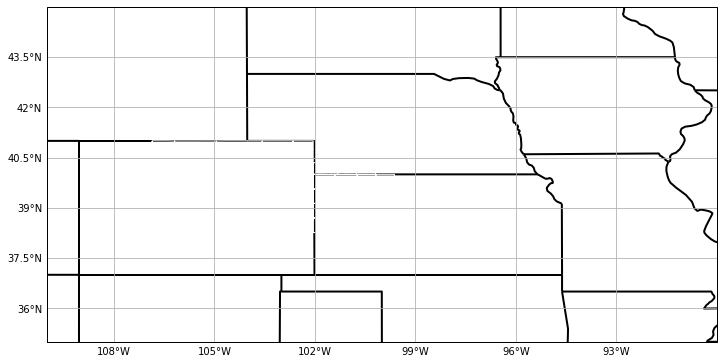

In [15]:
fig, ax = make_map(bbox=bbox)
# Plot CWA counties
for i, geom in enumerate(counties):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in counties
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor="w") #'#86989B'
    ax.add_feature(shape_feature)

for i, geom in enumerate(counties2):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in counties2
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor="w")
    ax.add_feature(shape_feature)


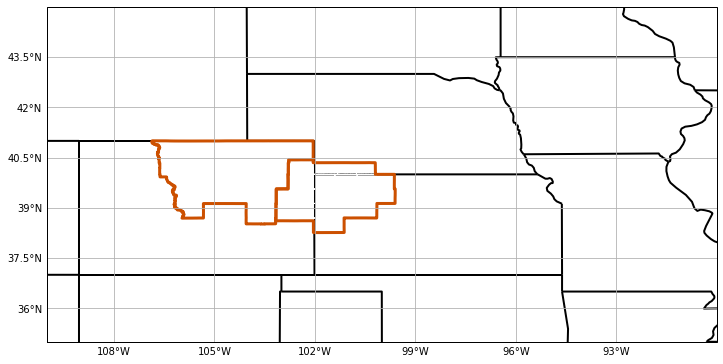

In [16]:
# Plot CWA envelope
for i, geom in enumerate(boundaries):
    gbounds = Polygon(geom)
    intersection = gbounds.intersection
    geoms = (intersection(geom)
         for geom in boundaries
         if gbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",linewidth=3.,edgecolor='#cc5000')
    ax.add_feature(shape_feature)

    
# Plot CWA envelope
for i, geom in enumerate(boundaries2):
    gbounds = Polygon(geom)
    intersection = gbounds.intersection
    geoms = (intersection(geom)
         for geom in boundaries2
         if gbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",linewidth=3.,edgecolor='#cc5000')
    ax.add_feature(shape_feature)

  
    
fig

In [17]:
#Sector = "GOES-East"
Sector = "EMESO-2"
Channel = "CH-13-10.35um"
#Channel = "Imager Visible"

In [18]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("satellite")
availableSectors = DataAccessLayer.getAvailableLocationNames(request)
availableSectors.sort()
request.setLocationNames(Sector)
availableProducts = DataAccessLayer.getAvailableParameters(request)
availableProducts.sort()
CH = availableProducts.index(Channel)
print("Index of list: ",availableProducts.index(Channel),
    "Data type:",type(availableProducts.index(Channel)))
request.setParameters(availableProducts[CH])
print(availableProducts[CH])
times = DataAccessLayer.getAvailableTimes(request)

Index of list:  15 Data type: <class 'int'>
CH-13-10.35um


grid size (500, 500)
grid extent [-110, -90, 35, 45]


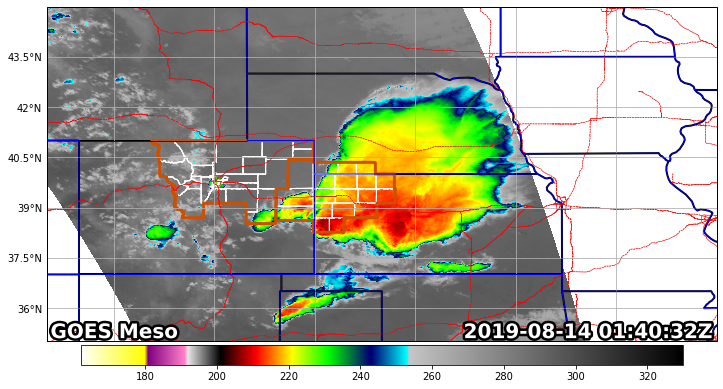

In [19]:

response = DataAccessLayer.getGridData(request, [times[-1]])
grid = response[0]
data = grid.getRawData()
#data = np.ma.masked_where(data<10,data)
lons,lats = grid.getLatLonCoords()
lats = np.nan_to_num(lats)
lons = np.nan_to_num(lons)
GOES_bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
#bbox = [-130.,-60,10.,60.]
#bbox = [-110.,-90,30.,45.]
print("grid size " + str(data.shape))
print("grid extent " + str(list(bbox)))





#fig, ax = make_map(bbox=bbox)
# State boundaries
state_borders = cfeature.NaturalEarthFeature(
                category='cultural', name='admin_1_states_provinces_lines',
                scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='b', linewidth=1, zorder=3)
country_borders = cfeature.NaturalEarthFeature(category='cultural',
            name='admin_0_countries',scale='50m', facecolor='none')

#reader = shpreader.Reader('/Users/chowdahead/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
#counties = list(reader.geometries())
#COUNTIES = cfeat.ShapelyFeature(counties,ccrs.PlateCarree())
#ax.add_feature(COUNTIES, facecolor='none',edgecolor='r')

reader = shpreader.Reader('/Users/chowdahead/Downloads/tl_2016_us_primaryroads/tl_2016_us_primaryroads.shp')
Roads = list(reader.geometries())
ROADS = cfeature.ShapelyFeature(Roads,ccrs.PlateCarree())
ax.add_feature(ROADS, facecolor='none',edgecolor='red',linestyle='--',linewidth=0.5)

ax.add_feature(country_borders,edgecolor='b',linewidth=0.2)
#ax.add_feature(states, linestyle='-',color='r')


cs = ax.pcolormesh(lons, lats, data, cmap=IR.IR_Colormap(),vmin=162.,vmax=330.) #cmap=IR.IR_Colormap(),vmin=162.,vmax=330.
cbar = fig.colorbar(cs, shrink=0.9, orientation='horizontal',fraction=0.031,pad=0.005,aspect=30)
#cbar.set_label(str(grid.getLocationName())+" " \
#               +str(grid.getParameter())+" " \
#               +str(grid.getDataTime().getRefTime()))

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05,map_projection=ccrs.PlateCarree())
#plt.colorbar(cs, cax=cax)

#plt.tight_layout()
# Label the plot
text_time = ax.text(.995, 0.01, 
        str(grid.getDataTime())+"Z",
        horizontalalignment='right', transform=ax.transAxes,
        color='white', fontsize=20, weight='bold',zorder=15)

text_time2 = ax.text(0.005, 0.01, 
        "GOES Meso",
        horizontalalignment='left', transform=ax.transAxes,
        color='white', fontsize=20, weight='bold',zorder=15)

outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
text_time.set_path_effects(outline_effect)
text_time2.set_path_effects(outline_effect)
fig